# Analisis exploratorio: Las personas y el terremoto

Trataremos de entender que le sucedio a las personas, teniendo en cuenta que es una dataset de edificios.

## Importo librerias y cargo los datos

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
edificios = pd.read_csv('datos/train_values.csv',dtype=datatypes)

In [3]:
#Datos de el daño por edificio
daños = pd.read_csv('datos/train_labels.csv',dtype={'building_id':np.int32,'damage_grade':'category'})

##  Daños y localizaciones
Veamos que zonas son las mas afectadas por el terremoto en terminos cuantitativos en las regiones más grandes

In [59]:
edificios_geo = edificios.loc[:,['building_id','geo_level_1_id']]
edificios_geo_daños = pd.merge(edificios_geo,daños,on='building_id',how='inner').groupby(['geo_level_1_id','damage_grade']).count().unstack()
edificios_geo_daños.head(3)

building_id           
damage_grade             1     2    3
geo_level_1_id                       
0                      337  3075  599
1                      411  1985  305
2                       85   610  236

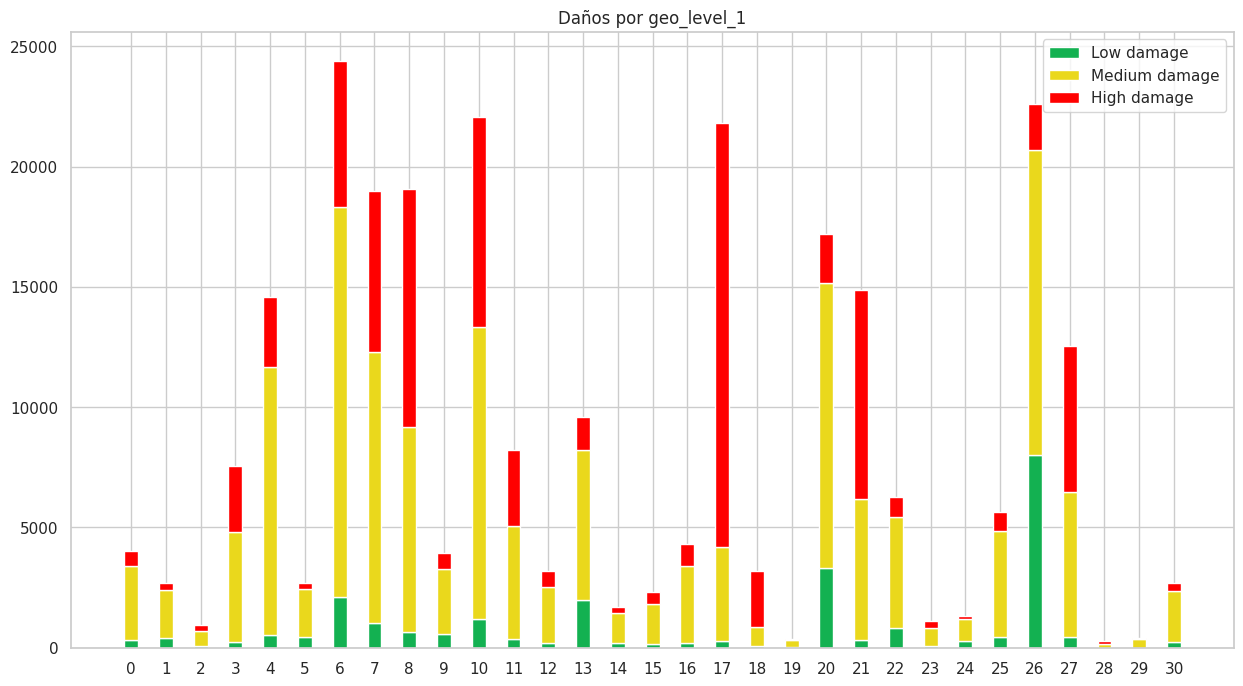

In [60]:
labels = edificios_geo_daños.index.to_list()
low_affected = np.array(edificios_geo_daños[('building_id','1')].to_list())
medium_affected = np.array(edificios_geo_daños[('building_id','2')].to_list())
high_affected = np.array(edificios_geo_daños[('building_id','3')].to_list())

width = 0.4
fig, ax = plt.subplots(figsize=(15,8))

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Daños por geo_level_1')
ax.legend()
plt.xticks(x)
plt.show()